## prove iris

In [1]:
import numpy as np
from scipy.linalg import block_diag
from math import factorial
from discopy import cat, monoidal
from discopy.monoidal import PRO
from discopy.tensor import Dim
from itertools import permutations as pr
SEED = 420
import numpy as np; np.random.seed(SEED)
from matplotlib import pyplot as plt
from noisyopt import minimizeSPSA
from time import time 

## creazione data set e inizializzazione input

In [2]:
width, depth = 4, 2  # width and depth of the piece of chip for one word

n_photons = 2
input_modes = output_modes = [0, 1, 1, 0]

bias, weight = -0.7, 5  # bias and weight for the classical post-processing

n_iter, alpha, gamma = 100, 0.602, 0.101  # optimization, hyper-parameters

SEED = 420

In [3]:
E = [x if not i else x + str(i + 1) 
     for i in range(1) for x in ["Alice", "Bob", "Claire", "Dave", "Eve", "Fred"]]
R = ["loves", "kills", "hates"]

print("Nouns: {}".format(', '.join(E)))
print("Verbs: {}".format(', '.join(R)))

Nouns: Alice, Bob, Claire, Dave, Eve, Fred
Verbs: loves, kills, hates


108 subject-verb-object sentences:


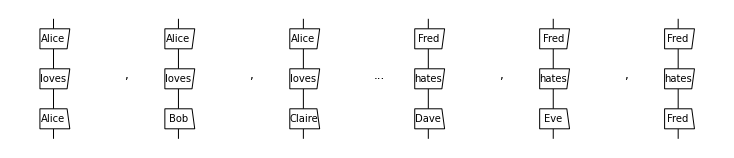

In [4]:
from discopy import Ty, Word, drawing

n = Ty('n')

class SimpleWord(Word):
    """ Word boxes with `dom == cod == n`. """
    def __init__(self, name, dom=n, cod=n, data=None, _dagger=False):
        super().__init__(name, dom=dom, cod=cod, data=data, _dagger=_dagger)

corpus = {
    ' '.join([x, r, y]):
    SimpleWord(x) >> SimpleWord(r) >> SimpleWord(y).dagger()
    for x in E for r in R for y in E}

print("{} subject-verb-object sentences:".format(len(corpus)))
start = drawing.Equation(*list(corpus.values())[:3], symbol=',')
end = drawing.Equation(*list(corpus.values())[-3:], symbol=',')
drawing.equation(start, end, symbol='...', asymmetry=5e-2, figsize=(10, 2), draw_type_labels=False)

In [5]:
## optics functions

def npperm(M):
    """
    Numpy code for computing the permanent of a matrix,
    from https://github.com/scipy/scipy/issues/7151
    """
    n = M.shape[0]
    d = np.ones(n)
    j = 0
    s = 1
    f = np.arange(n)
    v = M.sum(axis=0)
    p = np.prod(v)
    while (j < n - 1):
        v -= 2 * d[j] * M[j]
        d[j] = -d[j]
        s = -s
        prod = np.prod(v)
        p += s * prod
        f[0] = 0
        f[j] = f[j + 1]
        f[j + 1] = j + 1
        j = f[0]
    return p / 2 ** (n - 1)


@monoidal.Diagram.subclass
class Diagram(monoidal.Diagram):
    """
    Linear optical network seen as a diagram of beam splitters, phase shifters
    and Mach-Zender interferometers.

    >>> mach = lambda x, y: PhaseShift(x) @ Id(PRO(1)) >> BeamSplitter(y)
    >>> assert np.allclose(MZI(0.4, 0.9).array, mach(0.4, 0.9).array)
    >>> MZI(0, 0).amp(1, [1, 0], [0, 1])
    (1+0j)
    >>> assert np.allclose((BeamSplitter(0.4) >> BeamSplitter(0.4)).array,\
                           Id(PRO(2)).array)
    >>> grid = MZI(0.5, 0.3) @ MZI(0.5, 0.3) >> MZI(0.5, 0.3) @ MZI(0.5, 0.3)
    >>> np.absolute(grid.amp(7, [1, 3, 2, 1], [1, 3, 3, 0])) ** 2
    0.01503226280870989
    """
    def __repr__(self):
        return super().__repr__().replace('Diagram', 'optics.Diagram')

    @property
    def array(self):
        """
        The array corresponding to the diagram.
        Builds a block diagonal matrix for each layer and then multiplies them
        in sequence.

        >>> MZI(0, 0).array
        array([[ 0.+0.j,  1.+0.j],
               [ 1.+0.j, -0.+0.j]])
        """
        scan, array = self.dom, np.identity(len(self.dom))
        for box, off in zip(self.boxes, self.offsets):
            left, right = len(scan[:off]), len(scan[off + len(box.dom):])
            array = np.matmul(array, block_diag(np.identity(left), box.array,
                                                np.identity(right)))
        return array

    def amp(self, n_photons, x, y, permanent=npperm):
        """
        Evaluates the amplitude of an optics.Diagram on input x and output y,
        where x and y are lists of natural numbers summing to n_photons.

        Parameters
        ----------
        n_photons : int
            Number of photons
        x : List[int]
            Input vector of occupation numbers
        y : List[int]
            Output vector of occupation numbers
        permanent : callable, optional
            Use another function for computing the permanent
            (e.g. from thewalrus)

        >>> network = PhaseShift(0.4) @ Id(2) @ PhaseShift(0.5)\
                      >> MZI(0.4, 0.3) @ MZI(0.2, 0.5)
        >>> amplitude = network.amp(2, [1, 0, 0, 1], [0, 1, 1, 0])
        >>> amplitude
        (0.2562725928380136+0.9231201340089097j)
        >>> probability = np.abs(amplitude) ** 2
        >>> probability
        0.9178264236525457
        >>> MZI(0, 0).amp(1, [1, 0], [0, 1])
        (1+0j)
        >>> MZI(0, np.pi).amp(1, [1, 0], [1, 0])
        (1+0j)
        >>> MZI(0, 0).amp(2, [1, 1], [1, 0])
        0
        """
        if sum(x) != sum(y):
            return 0
        n_modes = len(self.dom)
        unitary = self.array
        matrix = np.stack([unitary[:, i] for i in range(n_modes)
                          for j in range(y[i])], axis=1)
        matrix = np.stack([matrix[i] for i in range(n_modes)
                          for j in range(x[i])], axis=0)
        divisor = np.sqrt(np.prod([factorial(n) for n in x + y]))
        amp = permanent(matrix) / divisor
        return amp


    def amp_dist(self, n_photons, x, y, permanent=npperm):
        """
        Evaluates the probability of an optics.Diagram on input x and output y,
        where x and y are lists of natural numbers summing to DISTINGUISHABLE n_photons. 

        Parameters
        ----------
        n_photons : int
            Number of photons
        x : List[int]
            Input vector of occupation numbers
        y : List[int]
            Output vector of occupation numbers
        permanent : callable, optional
            Use another function for computing the permanent
            (e.g. from thewalrus)

        >>> network = PhaseShift(0.4) @ Id(2) @ PhaseShift(0.5)\
                      >> MZI(0.4, 0.3) @ MZI(0.2, 0.5)
        >>> probability = network.amp(2, [1, 0, 0, 1], [0, 1, 1, 0])
        >>> MZI(0, 0).amp(1, [1, 0], [0, 1])
        (1+0j)
        >>> MZI(0, np.pi).amp(1, [1, 0], [1, 0])
        (1+0j)
        >>> MZI(0, 0).amp(2, [1, 1], [1, 0])
        0
        """

        n_modes = len(self.dom)
        unitary = self.array
        if sum(x) != sum(y):
            return 0
        i=[]
        o=[]
        for xx in range(len(x)):
            if x[xx] > 0:
                for z in range(x[xx]):
                    i.append(xx)
        for xx in range(len(y)):
            if y[xx] > 0:
                for z in range(y[xx]):
                    o.append(xx)        
        p=0;
        pm=list(set(pr(o)));
        for kk in range(len(pm)):
            u=1;
            for k in range(len(i)):
                u*=abs(unitary[i[k], pm[kk][k]])**2;
            p+=u;   
        pio=p
        return(pio)  
            
    def amp_CL(self, n_photons, x, y, permanent=npperm):
        """
        Evaluates the light intensity rate at the output of an optics.Diagram, when sending incoherent light on input x and 
        measuring the intensity on output y.
        x and y are lists of natural numbers, e.g. x=[0,1,1,0] means I am sending incoherent light from modes 2 and 3,
        while y=[1,1,1,0], means I am measuring the intensity from output modes 1,2 and 3. If y=[1,1,1,1] the probability is trivially 1.

        Parameters
        ----------
        n_photons : int
            Number of photons
        x : List[int]
            0 means no light is being injected, 1 means a light beam is being injected, e.g. [1,1,0,0] means I am
            sending light from mode 1 and 2
        y : List[int]
            0 means I am not measuring on that output mode, 1 means I am measuring intensity there, e.g. [1,1,0,0] means I am
            measuring light intensities from mode 1 and 2
        permanent : callable, optional
            Use another function for computing the permanent
            (e.g. from thewalrus)

        >>> network = PhaseShift(0.4) @ Id(2) @ PhaseShift(0.5)\
                      >> MZI(0.4, 0.3) @ MZI(0.2, 0.5)
        >>> probability = network.amp(2, [1, 0, 0, 1], [0, 1, 1, 0])
        >>> MZI(0, 0).amp(1, [1, 0], [0, 1])
        (1+0j)
        >>> MZI(0, np.pi).amp(1, [1, 0], [1, 0])
        (1+0j)
        >>> MZI(0, 0).amp(2, [1, 1], [1, 0])
        0
        """
            n_modes = len(self.dom)
            unitary = self.array
            i=[]
            o=[]
            for xx in range(len(x)):
                if x[xx] > 0:
                    for z in range(x[xx]):
                        i.append(xx)
            for xx in range(len(y)):
                if y[xx] > 0:
                    for z in range(y[xx]):
                        o.append(xx) 
            u=0
            for k in range(len(i)):
                for kk in range(len(o)):
                    u=u+abs(unitary[i[k], o[kk]])**2
            u=u/n_photons
            return(u)  
    
class Box(Diagram, monoidal.Box):
    """
    Box in an optics.Diagram
    """
    def __init__(self, name, dom, cod, data, **params):
        if not isinstance(dom, PRO):
            raise TypeError(messages.type_err(PRO, dom))
        if not isinstance(cod, PRO):
            raise TypeError(messages.type_err(PRO, cod))
        monoidal.Box.__init__(self, name, dom, cod, data=data, **params)
        Diagram.__init__(self, dom, cod, [self], [0], layers=self.layers)

    def __repr__(self):
        return super().__repr__().replace('Box', 'optics.Box')

    @property
    def array(self):
        """ The array inside the box. """
        return np.array(self.data).reshape(
            Dim(len(self.dom)) @ Dim(len(self.cod)) or (1, ))


class Id(monoidal.Id, Diagram):
    """
    Identity optics.Diagram
    """
    def __init__(self, dom=PRO()):
        if isinstance(dom, int):
            dom = PRO(dom)
        monoidal.Id.__init__(self, dom)
        Diagram.__init__(self, dom, dom, [], [], layers=cat.Id(dom))


Diagram.id = Id


class PhaseShift(Box):
    """
    Phase shifter

    Parameters
    ----------
    phase : float
    """
    def __init__(self, phase):
        self.phase = phase
        super().__init__('Phase shift', PRO(1), PRO(1), [phase])

    @property
    def array(self):
        return np.array(np.exp(2j * np.pi * self.phase))


class BeamSplitter(Box):
    """
    Beam splitter

    Parameters
    ----------
    angle : float
    """
    def __init__(self, angle):
        self.angle = angle
        super().__init__('Beam splitter', PRO(2), PRO(2), [angle])

    @property
    def array(self):
        cos, sin = np.cos(np.pi * self.angle), np.sin(np.pi * self.angle)
        return np.array([sin, cos, cos, -sin]).reshape((2, 2))


class MZI(Box):
    """
    Mach-Zender interferometer

    Parameters
    ----------
    phase, angle : float
    """
    def __init__(self, phase, angle):
        self.phase, self.angle = phase, angle
        super().__init__('MZI', PRO(2), PRO(2), [phase, angle])

    @property
    def array(self):
        cos, sin = np.cos(np.pi * self.angle), np.sin(np.pi * self.angle)
        exp = np.exp(2j * np.pi * self.phase)
        return np.array([exp * sin, exp * cos, cos, -sin]).reshape((2, 2))

    def dagger(self):
        return MZI(-self.phase, self.angle)


class Functor(monoidal.Functor):
    def __init__(self, ob, ar):
        super().__init__(ob, ar, ob_factory=PRO, ar_factory=Diagram)


        

In [6]:
#controllo normalizzazione
t=[]
modes=np.array([0,0,1,1,2,2,3,3])
comb=set(it.combinations(modes, 2))
combs=list(comb)
p_bs=0
p_dist=0
for y in combs:
    output=[0,0,0,0]
    for xx in range(len(y)):
        output[y[xx]]+=1
    print(output)
    p_bs=p_bs+probability(F(params0)(corpus["Alice loves Bob"]).amp(2, [0,1,1,0],output))
    p_dist=p_dist+F(params0)(corpus["Alice loves Bob"]).amp_dist(2, [0,1,1,0],output)  
F(params0)(corpus["Alice kills Eve"]).amp_CL(2, [0,1,1,0],[1,0,0,0])+\
F(params0)(corpus["Alice kills Eve"]).amp_CL(2, [0,1,1,0],[0,1,0,0])+\
F(params0)(corpus["Alice kills Eve"]).amp_CL(2, [0,1,1,0],[0,0,1,0])+\
F(params0)(corpus["Alice kills Eve"]).amp_CL(2, [0,1,1,0],[0,0,0,1])

NameError: name 'it' is not defined

In [ ]:
t=[]
modes=np.array([0,0,1,1,2,2,3,3])
comb=set(it.combinations(modes, 2))
combs=list(comb)
p_cl=0
for y in combs:
    output=[0,0,0,0]
    for xx in range(len(y)):
        output[y[xx]]+=1
    print(output)
    p_bs=p_bs+probability(F(params0)(corpus["Alice loves Bob"]).amp(2, [0,1,1,0],output))
    p_dist=p_dist+F(params0)(corpus["Alice loves Bob"]).amp_dist(2, [0,1,1,0],output)  

In [124]:
p_bs

1.0000000000000004

In [125]:
p_dist

1.0000000000000004

In [7]:
#costruisce il chip

def ansatz(params):
    depth, half_width, _ = params.shape
    chip = Id(2 * half_width)
    for i in range(depth):
        chip >>= Id().tensor(*[
                MZI(*params[i, j]) for j in range(half_width)])\
            if not i % 2 else Id(1).tensor(*[
                MZI(*params[i, j]) for j in range(half_width - 1)]) @ Id(1)
    return chip

Ansatz for 'Bob' (6 parameters):


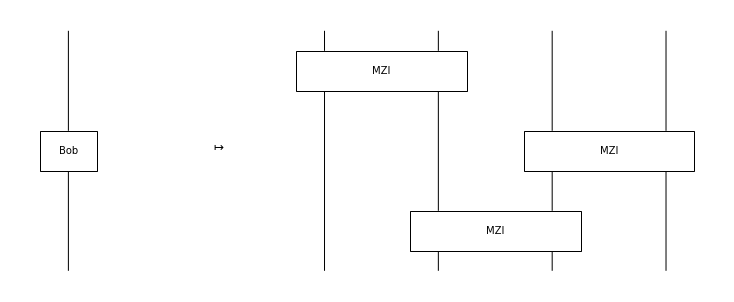

Total: 9 * 6 = 54 parameters.
[0.31564591 0.45303068 0.26698226 ... 0.25445189 0.35811394 0.50401754]


In [8]:
n_params = 2 * (depth * width // 2 - depth // 2)

random_params = lambda: np.random.uniform(size=(len(E + R), depth, width // 2, 2))

params0 = random_params()

print("Ansatz for 'Bob' ({} parameters):".format(n_params))

drawing.equation(
    SimpleWord('Bob'), ansatz(params0[1]),
    draw_type_labels=False, symbol='$\\mapsto$', figsize=(10, 4))

print("Total: {} * {} = {} parameters.".format(len(E + R), n_params, len(E + R) * n_params))
print(params0.flatten())

## giro di prova

Ansatz for 'Alice loves Bob':


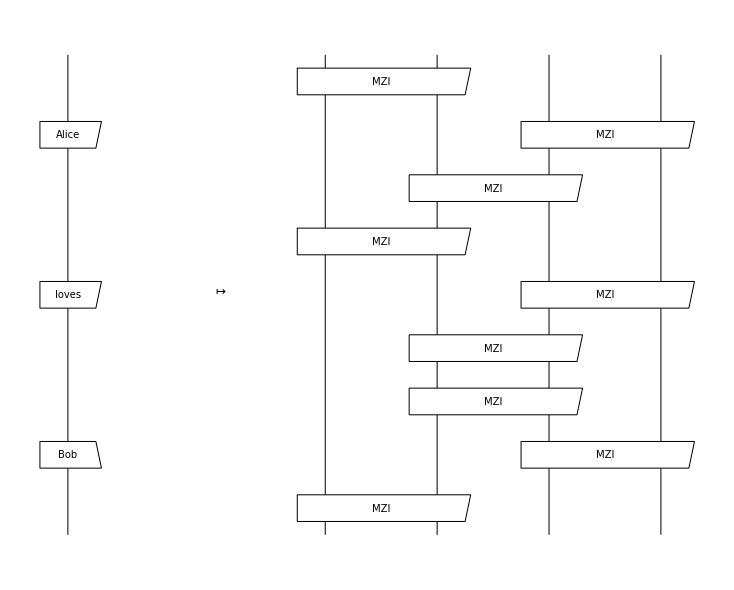

In [9]:
F = lambda params: Functor(
    ob={n: Ty(1) ** width},
    ar={SimpleWord(w): ansatz(params[i]) for i, w in enumerate(E + R)})

F0 = F(params0)

print("Ansatz for 'Alice loves Bob':")
drawing.equation(
    corpus["Alice loves Bob"], F0(corpus["Alice loves Bob"]),
    symbol='$\\mapsto$', figsize=(10, 8), draw_type_labels=False, asymmetry=5e-2)

activation = lambda x: 1 / (1 + np.exp(-x))
post_processing = lambda x: activation(x * weight + bias)

In [10]:
#generazione dataset con valori di true e false

probability = lambda amplitude: np.absolute(amplitude) ** 2

def evaluate(params, sentence):
    params = params.reshape(params0.shape)
    return post_processing(probability(
        F(params)(corpus[sentence]).amp(
            n_photons, input_modes, output_modes)))

print(print(params0.flatten()))

%time scores = {sentence: evaluate(params0, sentence) for sentence in corpus}

print("Does Fred love Eve? {} ({:.2F})".format(
    "Yes" if scores["Fred loves Eve"] > .5 else "No", scores["Fred loves Eve"]))

[0.31564591 0.45303068 0.26698226 ... 0.25445189 0.35811394 0.50401754]
None
CPU times: user 1.03 s, sys: 5.72 ms, total: 1.04 s
Wall time: 1.03 s
Does Fred love Eve? Yes (0.51)


Min: 0.34 (Eve kills Fred)
Max: 0.78 (Eve hates Claire)
Mean: 0.47
Standard deviation: 0.10

38 true sentences (score > .5)


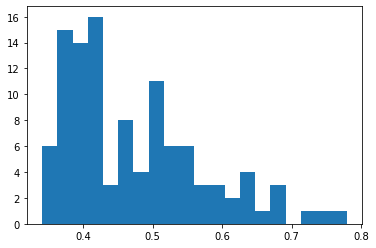

In [11]:
X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

Does Fred love Eve? Yes (0.51)
Min: 0.34 (Eve kills Fred)
Max: 0.78 (Eve hates Claire)
Mean: 0.47
Standard deviation: 0.10

38 true sentences (score > .5)


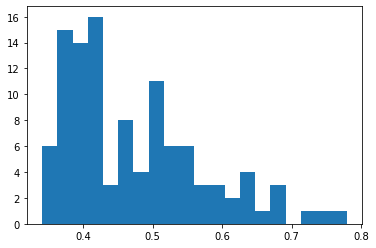

In [12]:
#evaluation per fotoni distinguibili

def evaluate_dist(params, sentence):
    params = params.reshape(params0.shape)
    return post_processing(
        F(params)(corpus[sentence]).amp_dist(
            n_photons, input_modes, output_modes))

#%time scores = {sentence: evaluate_dist(params0, sentence) for sentence in corpus}

print("Does Fred love Eve? {} ({:.2F})".format(
    "Yes" if scores["Fred loves Eve"] > .5 else "No", scores["Fred loves Eve"]))

X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

Does Fred love Eve? Yes (0.51)
Min: 0.34 (Eve kills Fred)
Max: 0.78 (Eve hates Claire)
Mean: 0.47
Standard deviation: 0.10

38 true sentences (score > .5)


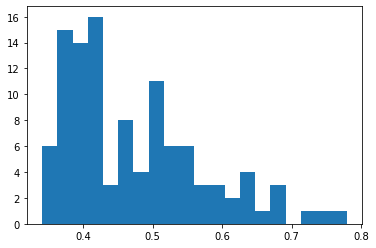

In [13]:
#evaluation per luce classica (fasci che non interferiscono)

params0 = random_params()

def evaluate_CL(params, sentence):
    params = params.reshape(params0.shape)
    return post_processing(
        F(params)(corpus[sentence]).amp_CL(
            n_photons, input_modes, output_modes))

#%time scores = {sentence: evaluate_CL(params0, sentence) for sentence in corpus}

print("Does Fred love Eve? {} ({:.2F})".format(
    "Yes" if scores["Fred loves Eve"] > .50 else "No", scores["Fred loves Eve"]))
X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

## ottimizzazione 

In [14]:
## separazione training set e testing set

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dataset = {sentence: int(score > .5) for sentence, score in scores.items()}

train, test = train_test_split(list(corpus), test_size=1 / 3, random_state=42)

print("Training set:\n{}\n{}".format('\n'.join(train[:3]), '...\n' if len(train) > 3 else ''))
print("Testing set:\n{}\n{}".format('\n'.join(test[:3]), '...\n' if len(test) > 3 else ''))

Training set:
Bob kills Eve
Claire loves Eve
Alice loves Fred
...

Testing set:
Eve loves Fred
Alice kills Eve
Alice loves Eve
...



In [15]:
def loss(corpus, params, mode):
    if mode=='bs':
        return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate(params, sentence))
        for sentence in corpus]))
    if mode=='dist':
        return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate_dist(params, sentence))
        for sentence in corpus]))
    if mode=='cl':
        return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate_CL(params, sentence))
        for sentence in corpus]))

testing_loss = lambda params: loss(test, params, 'bs')
training_loss = lambda params: loss(train, params, 'bs')

params_in = random_params().flatten()
params= params_in.copy()

print("Random initialisation, training_loss: {:.3f}, testing loss: {:.3f}".format(
    training_loss(params), testing_loss(params)))
print(params)
print()
print("Does Fred love Eve?")
print("Yes" if evaluate(params, 'Fred loves Eve') > .5 else "No")

Random initialisation, training_loss: 0.265, testing loss: 0.245
[0.04689655 0.14173987 0.25197844 ... 0.7641264  0.50990268 0.93593863]

Does Fred love Eve?
Yes


In [16]:
params_in

array([0.04689655, 0.14173987, 0.25197844, ..., 0.7641264 , 0.50990268,
       0.93593863])

In [18]:
params=params_in.copy()
print(params)

training_losses, testing_losses = [], []
start = time()
def callback(params):
    training_losses.append(training_loss(params))
    testing_losses.append(testing_loss(params))
    if not len(training_losses) % (n_iter // 10) or len(training_losses) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses), training_losses[-1], testing_losses[-1]))
        print(params)
        print()

result = minimizeSPSA(training_loss, params, paired=False, callback=callback, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

[0.04689655 0.14173987 0.25197844 ... 0.7641264  0.50990268 0.93593863]
Iteration 1, training_loss: 0.255, testing loss: 0.245
[0.07620502 0.1124314  0.22266997 ... 0.79343486 0.48059421 0.9652471 ]

Iteration 2, training_loss: 0.253, testing loss: 0.238
[0.0908463  0.09779012 0.20802869 ... 0.80807614 0.49523549 0.97988837]

Iteration 3, training_loss: 0.232, testing loss: 0.257
[0.13700692 0.0516295  0.16186807 ... 0.76191552 0.44907487 0.93372775]

Iteration 4, training_loss: 0.234, testing loss: 0.264
[0.10404412 0.0845923  0.12890528 ... 0.72895273 0.41611208 0.96669055]

Iteration 5, training_loss: 0.230, testing loss: 0.260
[0.08940039 0.09923603 0.143549   ... 0.74359646 0.43075581 0.95204682]

Iteration 6, training_loss: 0.228, testing loss: 0.257
[0.09779394 0.10762957 0.15194255 ... 0.73520291 0.43914935 0.96044037]

Iteration 7, training_loss: 0.222, testing loss: 0.236
[0.05312735 0.15229616 0.19660914 ... 0.69053633 0.39448277 1.00510695]

Iteration 8, training_loss: 0.22

In [19]:
print("Does Fred love Eve?")
print("Yes" if evaluate(result.x, 'Fred loves Eve') > .5 else "No")
print("time taken", time()-start)

Does Fred love Eve?
Yes
time taken 954.3084309101105


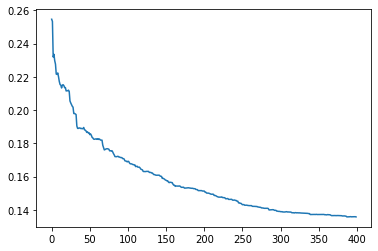

In [20]:
plt.plot(training_losses)

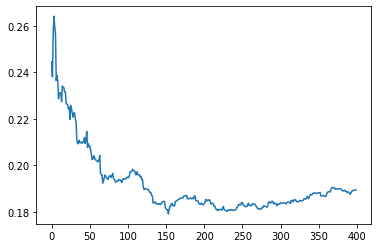

In [21]:
plt.plot(testing_losses)

In [20]:
testing_loss_dist = lambda params: loss(test, params, 'dist')
training_loss_dist = lambda params: loss(train, params, 'dist')

params=params_in.copy()

training_losses_dist, testing_losses_dist = [], []
start = time()
def callback_dist(params):
    training_losses_dist.append(training_loss_dist(params))
    testing_losses_dist.append(testing_loss_dist(params))
    if not len(training_losses_dist) % (n_iter // 10) or len(training_losses_dist) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses_dist), training_losses_dist[-1], testing_losses_dist[-1]))
        print(params)
        print()

#result_dist = minimizeSPSA(training_loss_dist, params, paired=False, callback=callback_dist, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

#print("Does Alice love Bob?")
#print("Yes" if evaluate_dist(result_dist.x, 'Alice loves Bob') > .5 else "No")
#print("time taken", time()-start)

In [24]:
print("Does Fred love Eve?")
print("Yes" if evaluate(result_dist.x, 'Fred loves Eve') > .5 else "No")
print("time taken", time()-start)

Does Fred love Eve?
Yes
time taken 1228.901316165924


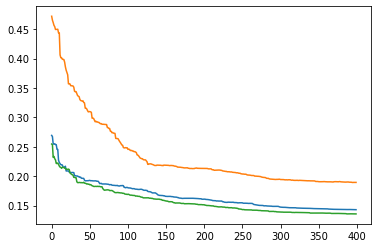

In [30]:
plt.plot(training_losses_dist)
plt.plot(training_losses_cl)
plt.plot(training_losses)

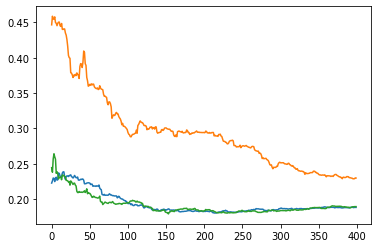

In [31]:
plt.plot(testing_losses_dist)
plt.plot(testing_losses_cl)
plt.plot(testing_losses)

In [19]:
testing_loss_cl = lambda params: loss(test, params, 'cl')
training_loss_cl = lambda params: loss(train, params, 'cl')

params=params_in.copy()
print(params)
training_losses_cl, testing_losses_cl = [], []
start = time()
def callback_cl(params):
    training_losses_cl.append(training_loss_cl(params))
    testing_losses_cl.append(testing_loss_cl(params))
    if not len(training_losses_cl) % (n_iter // 10) or len(training_losses_cl) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses_cl), training_losses_cl[-1], testing_losses_cl[-1]))
        print(params)
        print()

#result_cl = minimizeSPSA(training_loss_cl, params, paired=False, callback=callback_cl, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

#print("Does Alice love Bob?")
#print("Yes" if evaluate_CL(result_cl.x, 'Alice loves Bob') > .5 else "No")
#print("time taken", time()-start)

[0.04689655 0.14173987 0.25197844 ... 0.7641264  0.50990268 0.93593863]


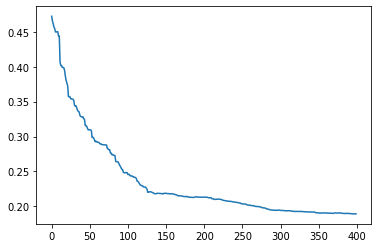

In [28]:
plt.plot(training_losses_cl)

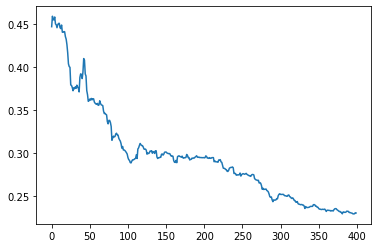

In [29]:
plt.plot(testing_losses_cl)

In [32]:
#bs
from sklearn.metrics import classification_report

y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate(result.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate(result.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.91      0.83      0.87        24

    accuracy                           0.92        72
   macro avg       0.91      0.90      0.90        72
weighted avg       0.92      0.92      0.92        72

              precision    recall  f1-score   support

           0       0.79      0.68      0.73        22
           1       0.59      0.71      0.65        14

    accuracy                           0.69        36
   macro avg       0.69      0.70      0.69        36
weighted avg       0.71      0.69      0.70        36



In [37]:
#dist
y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate_dist(result_dist.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate_dist(result_dist.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        48
           1       0.95      0.79      0.86        24

    accuracy                           0.92        72
   macro avg       0.93      0.89      0.90        72
weighted avg       0.92      0.92      0.91        72

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        22
           1       0.77      0.71      0.74        14

    accuracy                           0.81        36
   macro avg       0.80      0.79      0.79        36
weighted avg       0.80      0.81      0.80        36



In [38]:
#cl
from sklearn.metrics import classification_report
y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate_CL(result_cl.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate_CL(result_cl.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        48
           1       0.75      0.50      0.60        24

    accuracy                           0.78        72
   macro avg       0.77      0.71      0.72        72
weighted avg       0.77      0.78      0.76        72

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        22
           1       0.57      0.57      0.57        14

    accuracy                           0.67        36
   macro avg       0.65      0.65      0.65        36
weighted avg       0.67      0.67      0.67        36



## Average

In [22]:
params_in

array([0.04689655, 0.14173987, 0.25197844, ..., 0.7641264 , 0.50990268,
       0.93593863])

In [23]:
from sklearn.metrics import classification_report

In [24]:
y_train_true = []
y_test_true = []
y_train_pred = []
y_train_pred_dist = []
y_train_pred_cl = []
y_test_pred = []
y_test_pred_dist = []
y_test_pred_cl = []

def callback(params):
    training_losses.append(training_loss(params))
    testing_losses.append(testing_loss(params))
def callback_cl(params):
    training_losses_cl.append(training_loss_cl(params))
    testing_losses_cl.append(testing_loss_cl(params))
def callback_dist(params):
    training_losses_dist.append(training_loss_dist(params))
    testing_losses_dist.append(testing_loss_dist(params))
    
n_prove=5


for index in range(n_prove):
    print("giro # %d di %d" %(index+1, n_prove))
    training_losses_cl, testing_losses_cl = [], []
    training_losses, testing_losses= [], []
    training_losses_dist, testing_losses_dist = [], []
    y_train_true = y_train_true+[dataset[sentence] for sentence in train]
    y_test_true =y_test_true+[dataset[sentence] for sentence in test]
    print(params_in)
    params= params_in.copy()
    result = minimizeSPSA(training_loss, params, paired=False, callback=callback_dist, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)
    y_train_pred = y_train_pred+[evaluate(result.x, sentence) > .5 for sentence in train]
    y_test_pred = y_test_pred+[evaluate(result.x, sentence) > .5 for sentence in test]
    print("bs case train ", classification_report(y_train_true, y_train_pred))
    print("bs case test ", classification_report(y_test_true, y_test_pred))
    params= params_in.copy()
    result_cl = minimizeSPSA(training_loss_cl, params, paired=False, callback=callback_cl, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)
    y_train_pred_cl = y_train_pred_cl+[evaluate_CL(result_cl.x, sentence) > .5 for sentence in train]
    y_test_pred_cl = y_test_pred_cl+[evaluate_CL(result_cl.x, sentence) > .5 for sentence in test]
    print("cl case train ", classification_report(y_train_true, y_train_pred_cl))
    print("cl case test ", classification_report(y_test_true, y_test_pred_cl))
    params= params_in.copy()
    result_dist = minimizeSPSA(training_loss_dist, params, paired=False, callback=callback_dist, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)
    y_train_pred_dist = y_train_pred_dist+[evaluate_dist(result_dist.x, sentence) > .5 for sentence in train]
    y_test_pred_dist = y_test_pred_dist+[evaluate_dist(result_dist.x, sentence) > .5 for sentence in test]
    print("dist case train ", classification_report(y_train_true, y_train_pred_dist))
    print("dist case test ", classification_report(y_test_true, y_test_pred_dist))
    params_in = random_params().flatten()
    
    



giro # 1 di 5
[0.04689655 0.14173987 0.25197844 ... 0.7641264  0.50990268 0.93593863]
bs case train                precision    recall  f1-score   support

           0       0.82      0.98      0.90        48
           1       0.93      0.58      0.72        24

    accuracy                           0.85        72
   macro avg       0.88      0.78      0.81        72
weighted avg       0.86      0.85      0.84        72

bs case test                precision    recall  f1-score   support

           0       0.82      0.82      0.82        22
           1       0.71      0.71      0.71        14

    accuracy                           0.78        36
   macro avg       0.77      0.77      0.77        36
weighted avg       0.78      0.78      0.78        36

cl case train                precision    recall  f1-score   support

           0       0.79      0.96      0.87        48
           1       0.86      0.50      0.63        24

    accuracy                           0.81        7

KeyboardInterrupt: 

In [25]:
file_bs_test=open("y_test_true_bs.txt", "wb")
file_bs_train=open("y_train_true_bs.txt", "wb")
file_dist_test=open("y_test_true_dist.txt", "wb")
file_dist_train=open("y_train_true_dist.txt", "wb")
file_cl_test=open("y_test_true_cl.txt", "wb")
file_cl_train=open("y_train_true_cl.txt", "wb")

In [ ]:
import pickle
pickle.dump(y_test_pred_bs, file_bs_test)
pickle.dump(y_train_pred_bs, file_bs_train)
pickle.dump(y_test_pred_bs, file_dist_test)
pickle.dump(y_train_pred_bs, file_dist_train)
pickle.dump(y_test_pred_bs, file_cl_test)
pickle.dump(y_train_pred_bs, file_cl_train)